# Generating figures for paper

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

fsize = 8
tsize = 8
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('grid')
# plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# errbar_kwargs = dict(marker='.', markersize=3, capsize=3, elinewidth=1, lw=1)
# plot_kwargs = dict(marker='.', markersize=3, lw=1)
# errband_kwargs = dict(alpha=0.25)
errbar_kwargs = dict(estimator='mean', errorbar=('ci', 95), errwidth=1.25, capsize=0.05,)

save_dir = '../neurips/figs/experiments'

In [2]:
cmap = plt.cm.tab20

## Relational Games

In [3]:
relgames_data = pd.read_csv('figure_data/relgames/relgames_data.csv')

def process_groupname(group_name):
    task, model_name = group_name.split('__')
    return model_name


L, total_n_heads = 2, 2
filter_ = (relgames_data['n_layers'] == L) & ((relgames_data['n_heads_rca'] + relgames_data['n_heads_sa'] == total_n_heads) | (relgames_data['n_heads'] == total_n_heads)) & (relgames_data['train_size'] <= 25_000)
figure_data = relgames_data[filter_]

figure_data['Model'] = figure_data['group'].apply(process_groupname)

figure_data.rename(columns={'train_size': 'Training Set Size', 'test/acc_in_distribution': 'Generalization Accuracy', 'task': 'Task'}, inplace=True)

In [4]:
models = [
    'sa=2; d=128; L=2',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever'
    ]
model_name_map = {
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever': 'AbstractTransformer ($n_h^{sa}=1, n_h^{rca}=1$)',
    'sa=2; d=128; L=2': 'Transformer',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever': 'AbstractTransformer ($n_h^{sa}=0, n_h^{rca}=2$)'}
models = [model_name_map[m] for m in models]

tasks = ['same', 'occurs', 'xoccurs', '1task_between', '1task_match_patt']
task_name_map = {
    '1task_between': r'$\texttt{between}$', '1task_match_patt': r'$\texttt{match pattern}$',
    'same': r'$\texttt{same}$', 'occurs': r'$\texttt{occurs}$', 'xoccurs': r'$\texttt{xoccurs}$'}
tasks = [task_name_map[t] for t in tasks]

figure_data['Model'] = pd.Categorical(figure_data['Model'].map(model_name_map), models, ordered=True)
figure_data['Task'] = pd.Categorical(figure_data['Task'].map(task_name_map), tasks, ordered=True)


# bar plot figure
color_map_ = {
    'AbstractTransformer ($n_h^{sa}=1, n_h^{rca}=1$)': cmap(8), # purple
    'AbstractTransformer ($n_h^{sa}=0, n_h^{rca}=2$)': cmap(0), # blue
    'Transformer': cmap(6), # red
    # 'Transformer+': cmap(4),
    }


In [5]:
model_name_map.values()

dict_values(['AbstractTransformer ($n_h^{sa}=1, n_h^{rca}=1$)', 'Transformer', 'AbstractTransformer ($n_h^{sa}=0, n_h^{rca}=2$)'])

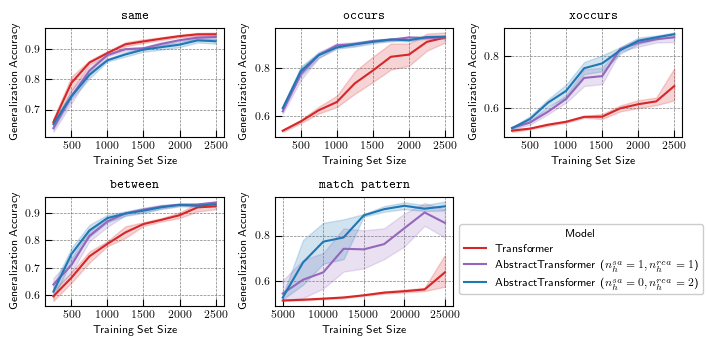

In [6]:
# tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data[task_filter]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    axes.append(ax)

fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.65, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/relgames_learning_curves.pdf')

## Math

In [7]:
# bar plot figure
color_map_ = {
    'AbstractTransformer (config 1)': cmap(8), # purple
    'AbstractTransformer (config 2)': cmap(0), # blue
    'Transformer': cmap(7), # lighter red
    'Transformer+': cmap(6), # red
    # 'Transformer+': cmap(4),
    }


models = {
    'ee=8; ea=0; de=8; da=0; dc=8; el=2; dl=2': 'Transformer',
    'e_sa=8; e_rca=0; d_sa=8; d_rca=0; d_cross=8; d=144; rca_type=NA, symbol_type=NA; el=2; dl=2': 'Transformer+',
    'e_sa=4; e_rca=4; d_sa=8; d_rca=0; d_cross=8; d=128; rca_type=disentangled_v2, symbol_type=pos_relative; el=2; dl=2': 'AbstractTransformer (config 1)',
    'e_sa=4; e_rca=4; d_sa=4; d_rca=4; d_cross=8; d=128; rca_type=disentangled_v2, symbol_type=pos_relative; el=2; dl=2': 'AbstractTransformer (config 2)',
    # 'e_sa=4; e_rca=4; d_sa=8; d_rca=0; d_cross=8; rca_dis=True, el=2; dl=2': 'AbstractTransformer (v1; OGRCA)',
    # 'e_sa=4; e_rca=4; d_sa=4; d_rca=4; d_cross=8; rca_dis=True, el=2; dl=2': 'AbstractTransformer (v2; OGRCA)',
    }

In [8]:
figure_data = pd.read_csv('figure_data/math/run_history_all.csv')

In [9]:
figure_data.rename(columns={
    'epoch': 'Epoch', 'interpolate_teacher_forcing_acc': 'Accuracy (Interpolation)', 'extrapolate_teacher_forcing_acc': 'Accuracy (Extrapolation)', 
    'train_teacher_forcing_acc': 'Accuracy (Training)', 'task': 'Task', 'group': 'Model'}, inplace=True)

def format_task(task):
    string = task.replace('__', r'\_\_')
    string = r"$\texttt{" + string + r"}$"
    return string
figure_data['Task'] = pd.Categorical(figure_data['Task'].map(format_task))
figure_data = figure_data[figure_data['Model'].isin(models.keys())]
figure_data['Model'] = pd.Categorical(figure_data['Model'].map(models), models.values(), ordered=True)

In [10]:
# TODO: need to run more trials for some, etc.
figure_data.groupby(['Model', 'Task'])['Accuracy (Training)'].aggregate('count')

Model                           Task                                    
Transformer                     $\texttt{algebra\_\_linear_1d}$             100
                                $\texttt{algebra\_\_sequence_next_term}$    100
                                $\texttt{calculus\_\_differentiate}$        100
                                $\texttt{polynomials\_\_add}$               100
                                $\texttt{polynomials\_\_expand}$            100
Transformer+                    $\texttt{algebra\_\_linear_1d}$             500
                                $\texttt{algebra\_\_sequence_next_term}$    500
                                $\texttt{calculus\_\_differentiate}$        500
                                $\texttt{polynomials\_\_add}$               500
                                $\texttt{polynomials\_\_expand}$            500
AbstractTransformer (config 1)  $\texttt{algebra\_\_linear_1d}$             964
                                $\texttt{algebr

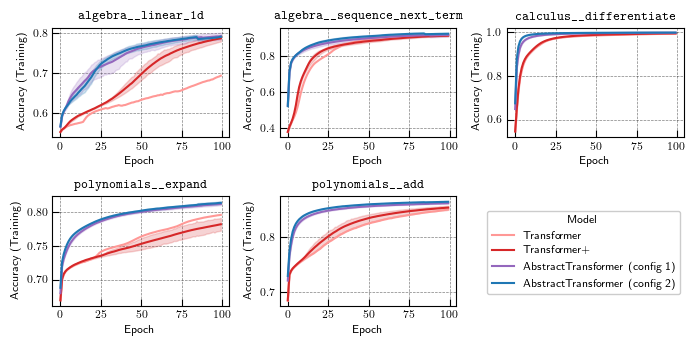

In [11]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data[task_filter]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Training)', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    axes.append(ax)

fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math_training_curves_trainacc.pdf')

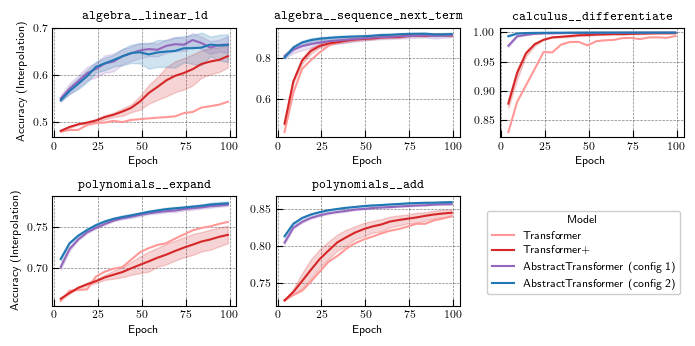

In [12]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data[task_filter]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Interpolation)', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    if (i % 3) != 0:
        ax.set_ylabel('')
    ax.set_title(task)
    axes.append(ax)

fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math_training_curves_interpolation.pdf')

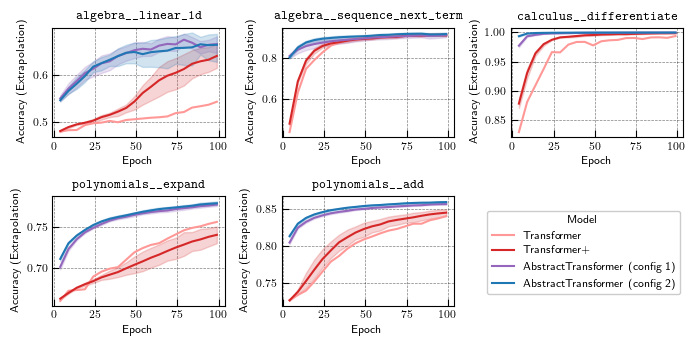

In [13]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data[task_filter]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Extrapolation)', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    axes.append(ax)

fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math_training_curves_extrapolation.pdf')

## Vision

## Language Modeling